How to find similar images using image as a query? We generally encode the image into a vector of d dimensions, then find the nearest neighbors to the vector.We can generally use neural nets for encoding the images,then just use cosine similarity to find the neighbors.

In [4]:
#we will use IMAGENETTE dataset, and use the famous VIT transformer model as this is might suit really well for this task of encoding things
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [ ]:
#!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
!tar -xvzf imagenette2-160.tgz

In [6]:
import os
os.listdir('imagenette2-160/')

['val', 'train', 'noisy_imagenette.csv', '.DS_Store']

In [9]:
import glob

In [10]:
from PIL import Image
from torchvision.utils import make_grid
from torchvision.io import decode_image
from pathlib import Path
import torchvision

plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [11]:
plt.rcParams["figure.figsize"] = (12,12)

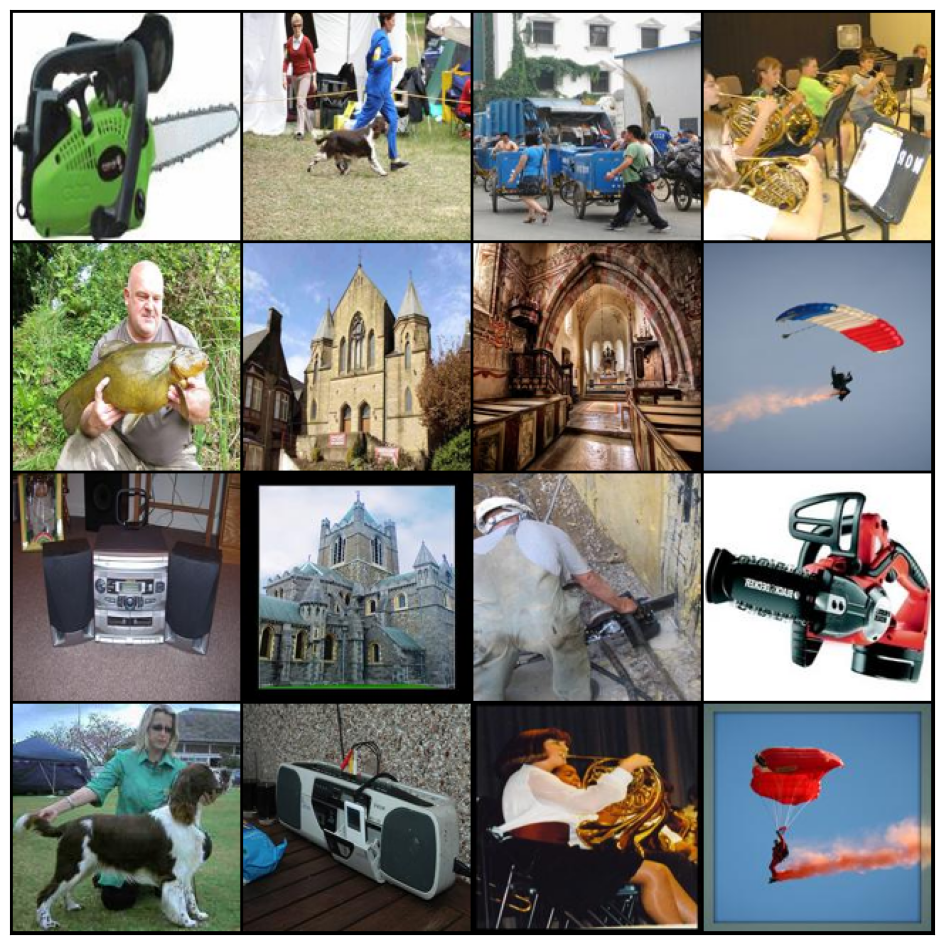

In [12]:
tmplist=[]
for i in np.random.choice(glob.glob('imagenette2-160/**/*.JPEG',recursive=True),16):
    tmp=Image.open(i)
    tmp=tmp.resize((160,160)).transpose(Image.ROTATE_90)
    try:tmplist.append(torch.tensor(np.array(tmp)).permute(2,1,0))
    except:pass
    if len(tmplist)>15:break
grid = make_grid(tmplist,nrow=4)
show(grid)

In [13]:
len(os.listdir('imagenette2-160/train'))# 11 classes, each very different from one another.

11

In [ ]:
from transformers import ViTImageProcessor, ViTModel

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

In [17]:
from tqdm import tqdm

In [29]:
tmp=[]
model.to('cuda')
for i in tqdm(sorted(glob.glob('imagenette2-160/**/*.JPEG',recursive=True))):
    image=Image.open(i)
    #print(image.shape)
    try:
        inputs = processor(images=image, return_tensors="pt",do_convert_rgb=True)
        inputs.to('cuda')
        outputs = model(**inputs)
        tmp.append(outputs.pooler_output.detach().cpu().numpy()[0])
    except: break

100%|██████████| 13394/13394 [04:03<00:00, 54.97it/s]


In [47]:
def plot_nearest_neighbors(index, image_embeddings, top_k=10):
    #We will find the nearest neighbors using dotproduct, based on cosine similarity, we will give the results
    query_image = image_embeddings[index]
    scores = np.dot(image_embeddings, query_image)
    scores /= np.linalg.norm(query_image)*np.linalg.norm(image_embeddings,axis=-1)
    top_indices = np.argsort(scores)[::-1][1:top_k+1]  # Exclude the query image itself
    neighbors = top_indices
    neighbor_scores = scores[top_indices]

    #plotting the given neighbors in a single row
    img_paths= sorted(glob.glob('imagenette2-160/**/*.JPEG',recursive=True))
    image= np.array(Image.open(img_paths[index]))
    image_list= [np.array(Image.open(img_paths[i])) for i in top_indices]
    fig, axes = plt.subplots(1, len(image_list) + 1, figsize=(15, 5))  # Adjust figsize as needed

    # Plot the single image
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title("Query Image")

    # Plot images from the list with scores
    for i, (img, score) in enumerate(zip(image_list, scores)):
        axes[i + 1].imshow(img)
        axes[i + 1].axis('off')
        axes[i + 1].set_title(f"{score:.2f}")  # Display score with 2 decimal places

    plt.tight_layout()
    plt.show()


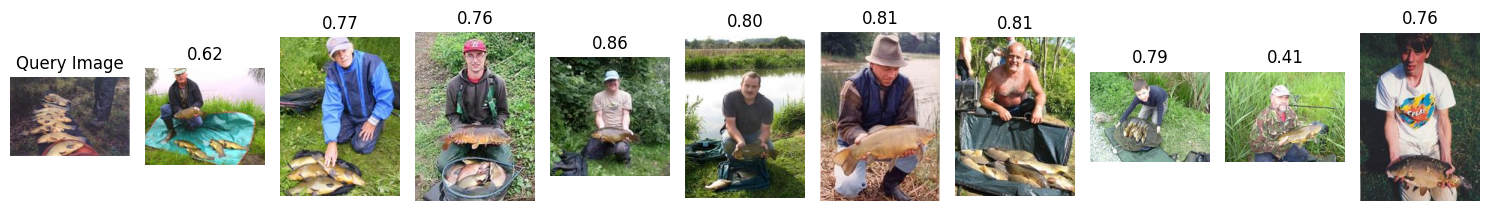

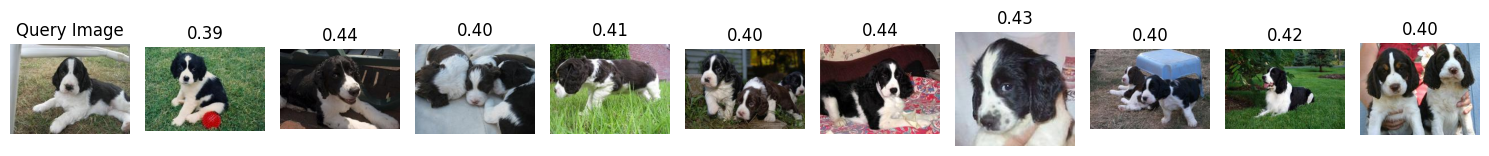

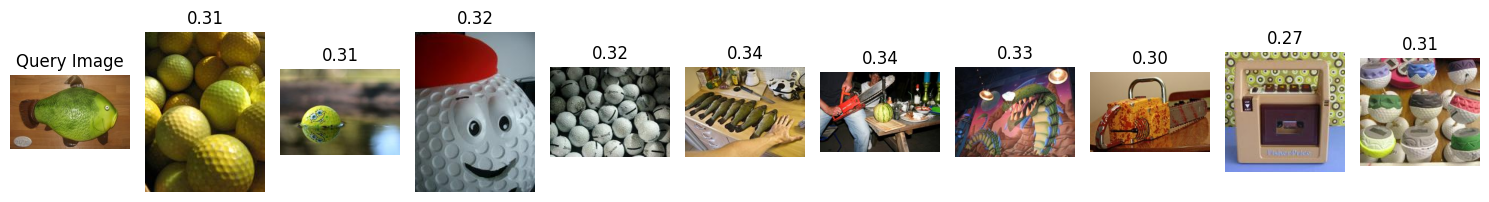

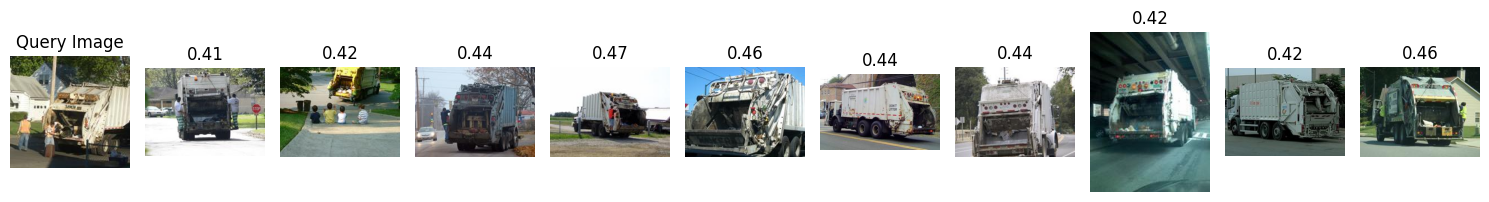

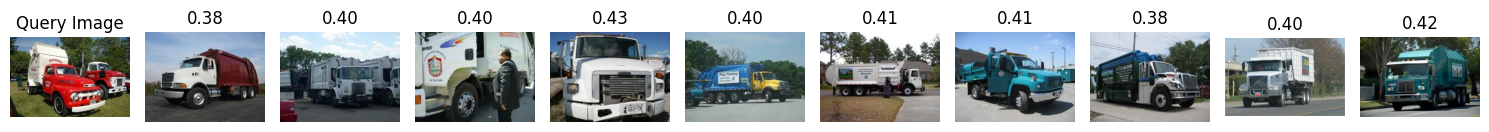

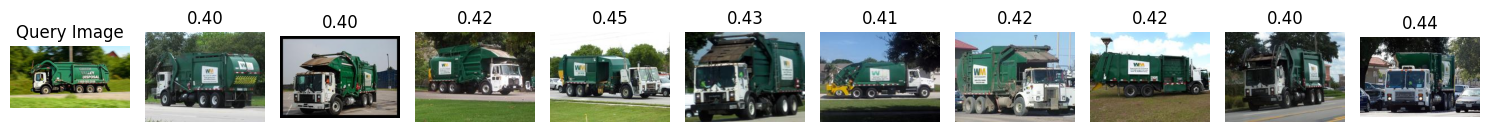

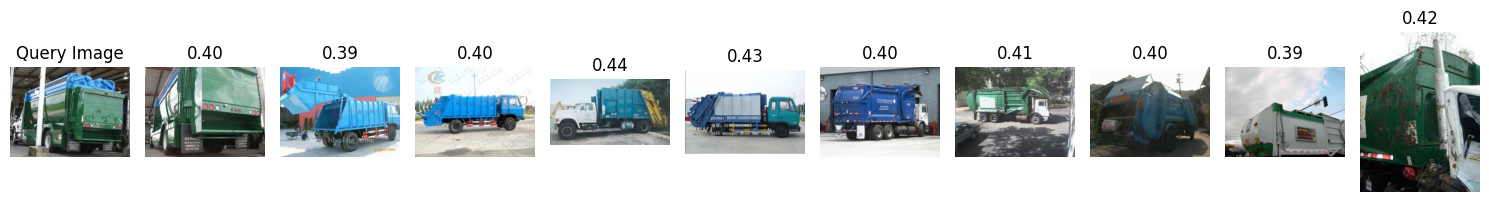

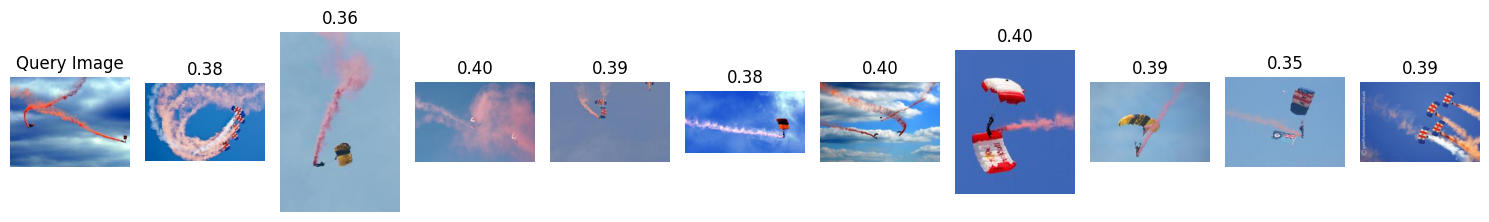

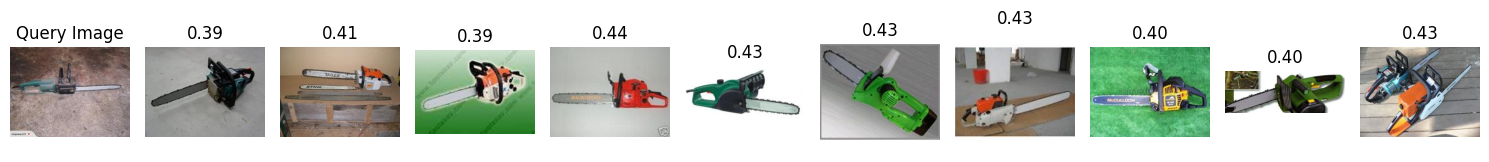

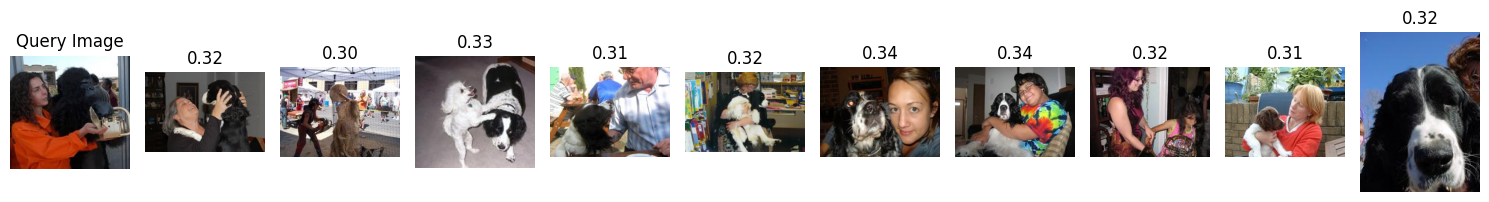

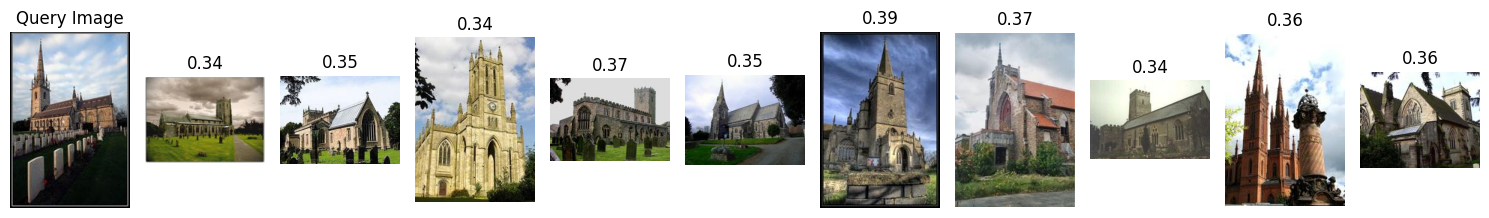

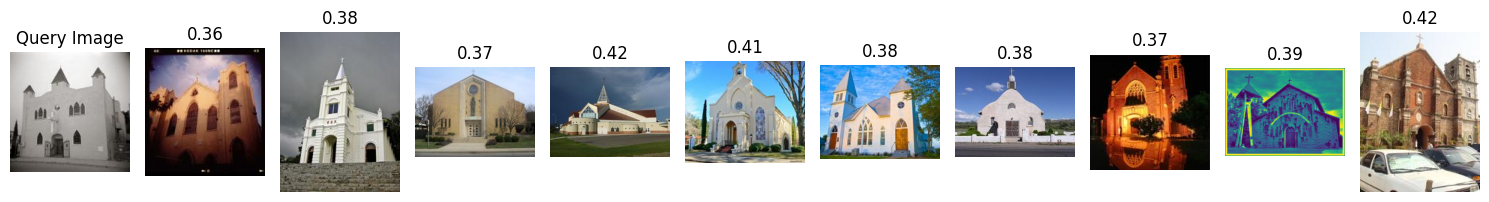

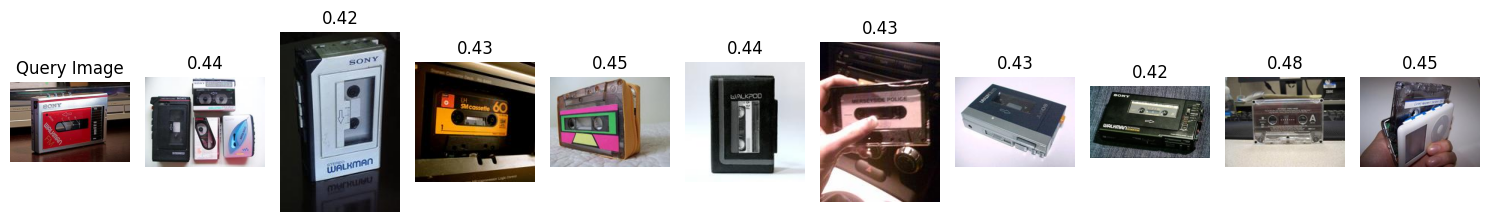

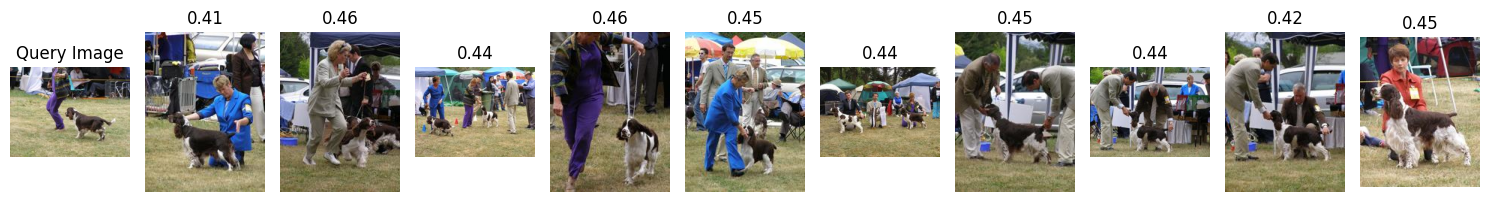

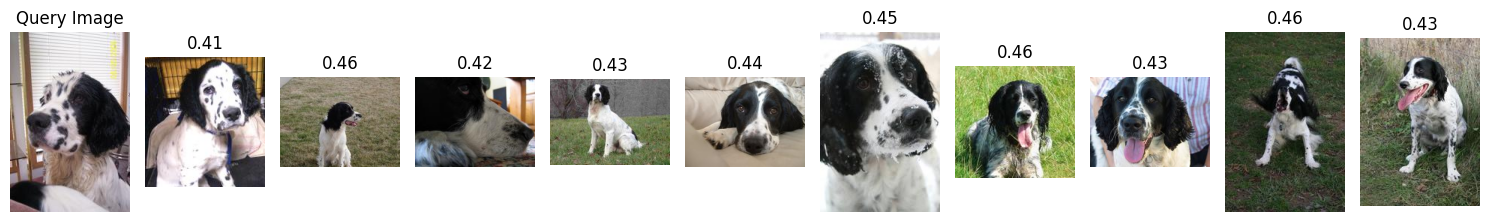

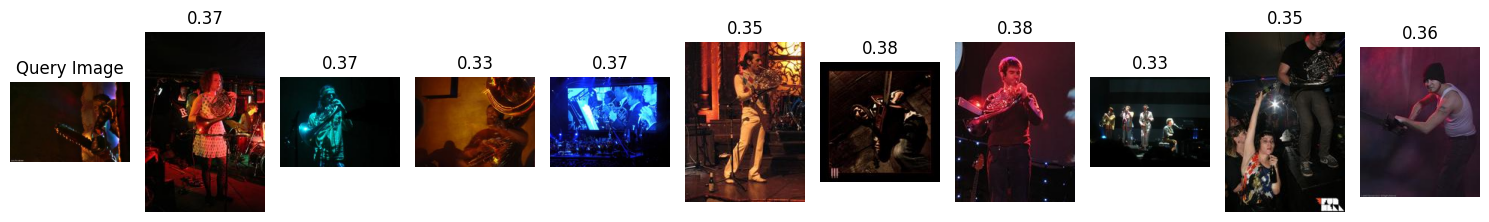

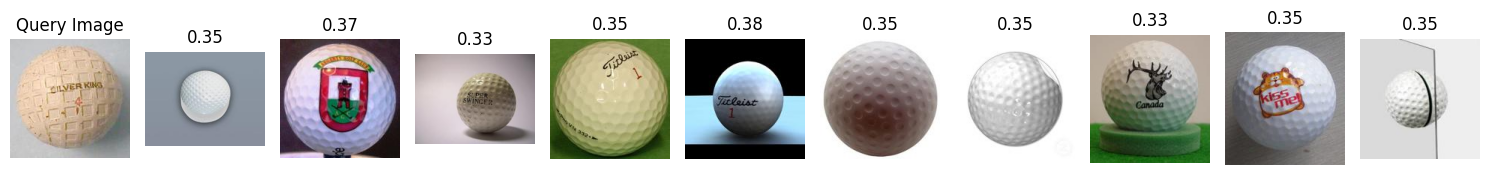

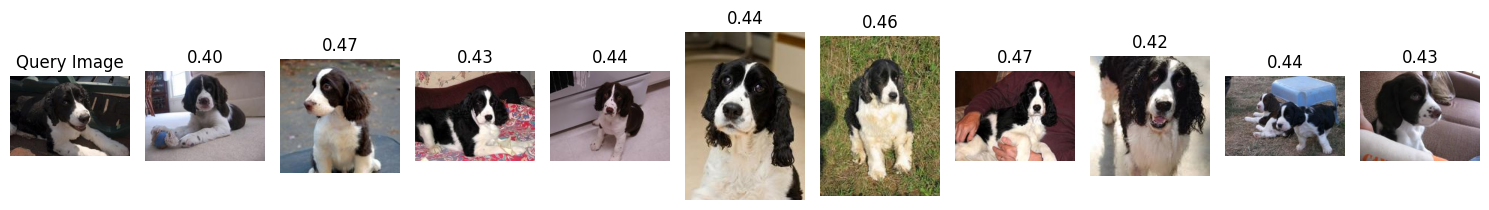

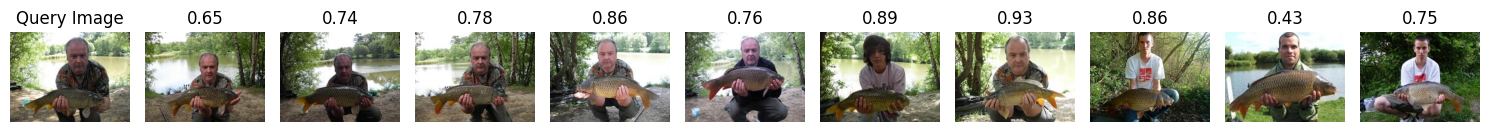

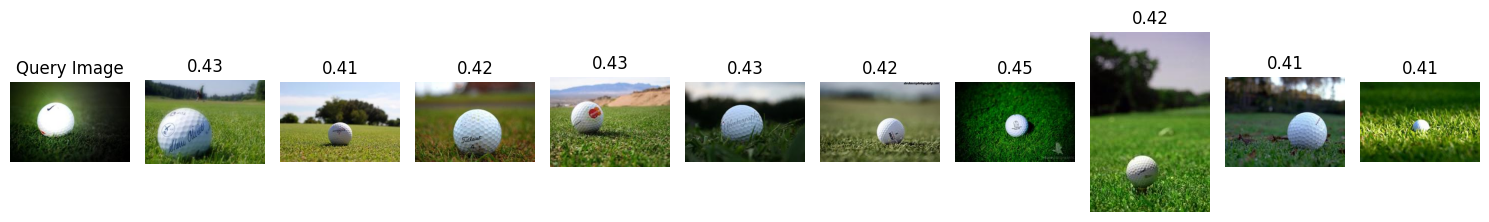

In [48]:
for _ in range(20):
    plot_nearest_neighbors(np.random.randint(0,len(tmp)),tmp)

As we can see, this is doing really well, all neighbors are really close to each other. This way we can search things by using an image.